In [1]:
import numpy as np
import pandas as pd
import torch
from cvxpy import transpose
from matplotlib.testing import set_reproducibility_for_testing
from torch.nn.functional import mse_loss
from sklearn.datasets import load_svmlight_file
from referencing.retrieval import to_cached_resource
import matplotlib.pyplot as plt
from tqdm import tqdm


torch.manual_seed(42)

### Инициализация классов для создания структуры распеределенного обучения

In [2]:
def default_reg(weights, lamb=0.01):
    return lamb * torch.sum(torch.pow(weights, 2))

def loss(x, b):
  return 1 / 2 * torch.sum(torch.pow(x - b, 2))


class BorderNode:
    def __init__(self, weights: torch.tensor, F: torch.tensor, reg_func=default_reg):
        self.weights = weights.detach().clone().requires_grad_()
        self.reg_func = reg_func
        self.F = F
        self.features_dim = F.shape[1]

    def request_from_central_node(self, y: torch.tensor, transpose=False):
        if transpose:
            return self.F.t() @ y
        return self.F @ y

    def return_grad(self, weights):
        weights_copied = weights.detach().clone()
        weights_copied.requires_grad_(True)
        reg = self.reg_func(weights_copied)
        grad_weights, = torch.autograd.grad(reg, weights_copied)
        return grad_weights

    def set_weights(self, w):
        self.weights = w.detach().clone().requires_grad_()


class CentralNode:
    def __init__(self, child_nodes: list[BorderNode], objects_amount: int, labels: torch.tensor):
        assert objects_amount == labels.shape[0], "Amount of samples in dataset must be equal to labels size"

        self.objects_amount = objects_amount
        self.child_nodes = child_nodes
        self.dims = [node.features_dim for node in child_nodes]  # + [self.objects_amount]

        torch.manual_seed(42)

        self.x = [
            torch.rand(dim) for dim in dims
        ]

        self.labels = labels
        self.n = len(child_nodes)

        for i, child_node in enumerate(self.child_nodes):
            child_node.set_weights(self.x[i])

    def get_grads(self, u):
        grads = []
        for i, border_node in enumerate(self.child_nodes):
            grad = border_node.return_grad(u[i])
            grads.append(grad)

        return grads

### Метод Linear Complexity SGD

In [3]:
class LiCoSGD:
    def __init__(self, centr: CentralNode, loss_func, gamma, tau):
        torch.manual_seed(42)  # Set the random seed
        self.centr = centr
        self.n = self.centr.n
        self.u = self.centr.x + [torch.rand(self.centr.objects_amount)]
        self.y = torch.rand(self.centr.objects_amount)
        self.gamma = gamma
        self.tau = tau
        self.loss_func = loss_func

        for i, child_node in enumerate(self.centr.child_nodes):
            child_node.set_weights(self.centr.x[i])

    def _get_z_grad(self, z):
        z_copy = z.detach().clone()
        z_copy.requires_grad_(True)
        loss = self.loss_func(z_copy, self.centr.labels)
        grad_z, = torch.autograd.grad(loss, z_copy)
        return grad_z

    def step(self):
        x_grads = self.centr.get_grads(self.u)
        z_grad = self._get_z_grad(self.u[self.n])
        w = [self.u[i] - self.gamma * x_grads[i] for i in range(self.n)] + [self.u[self.n] - self.gamma * z_grad]

        with torch.no_grad():
            components = [border_node.request_from_central_node(self.y, transpose=True) for i, border_node in
                          enumerate(self.centr.child_nodes)] + [-self.y]

            vector = [w[i] - self.gamma * components[i] for i in range(len(w))]

            l_multiplied_vectors = [
                                       border_node.request_from_central_node(
                                           vector[i])
                                       for
                                       i, border_node in enumerate(self.centr.child_nodes)
                                   ] + [- vector[self.n]]

            self.y = self.y + self.tau * torch.sum(torch.hstack([x.unsqueeze(1) for x in l_multiplied_vectors]), dim=1,
                                                   keepdim=False)

            components = [border_node.request_from_central_node(self.y, transpose=True) for i, border_node in
                          enumerate(self.centr.child_nodes)] + [-self.y]

            self.u = [w[i] - self.gamma * components[i] for i in range(len(w))]

        for i, child_node in enumerate(self.centr.child_nodes):
            child_node.set_weights(self.centr.x[i])

    def predict(self):
        with torch.no_grad():
            weights = self.u[:self.n]

            ans = torch.zeros(self.centr.objects_amount, dtype=torch.float32)
            for i in range(self.n):
                ans += self.centr.child_nodes[i].request_from_central_node(weights[i])

        return ans



### Метод Extra Gradient VFL

In [4]:
class EGVFL:
    def __init__(self, centr: CentralNode, loss_func, gamma):
        torch.manual_seed(42)
        self.centr = centr
        self.n = self.centr.n
        self.x = self.centr.x
        self.z = torch.rand(self.centr.objects_amount)
        self.y = torch.rand(self.centr.objects_amount)
        self.gamma = gamma
        self.loss_func = loss_func

        # for i, child_node in enumerate(self.centr.child_nodes):
        #     child_node.set_weights(self.x[i])

    def _get_z_grad(self, z):
        z_copy = z.detach().clone()
        z_copy.requires_grad_(True)
        loss = self.loss_func(z_copy, self.centr.labels)
        grad_z, = torch.autograd.grad(loss, z_copy)
        return grad_z

    def step(self):
        A_i_dot_x_ik = [border_node.request_from_central_node(self.x[i], transpose=False) for i, border_node in
                        enumerate(self.centr.child_nodes)]
        A_iT_dot_y_k = [border_node.request_from_central_node(self.y, transpose=True) for i, border_node in
                        enumerate(self.centr.child_nodes)]

        x_half = [
            self.x[i] - self.gamma * (A_iT_dot_y_k[i] + border_node.return_grad(self.x[i]))
            for i, border_node in enumerate(self.centr.child_nodes)
        ]

        # print(x_half)
        # x_half hadn't pushed to border

        z_half = self.z - self.gamma * (self._get_z_grad(self.z) - self.y)

        y_half = self.y + self.gamma * (torch.sum(torch.vstack(A_i_dot_x_ik), dim=-2) - z_half)

        A_i_dot_x_half_ik1 = [border_node.request_from_central_node(x_half[i], transpose=False) for i, border_node in
                              enumerate(self.centr.child_nodes)]
        # uses x_half without pushing
        A_iT_dot_y_half_ik1 = [border_node.request_from_central_node(y_half, transpose=True) for i, border_node in
                               enumerate(self.centr.child_nodes)]

        # different grad need x_half, kostil method
        x_new = [self.x[i] - self.gamma * (A_iT_dot_y_half_ik1[i] + border_node.return_grad(weights=x_half[i])) for
                 i, border_node in enumerate(self.centr.child_nodes)]

        z_new = self.z - self.gamma * (self._get_z_grad(z_half) - y_half)

        y_new = self.y + self.gamma * (torch.sum(torch.vstack(A_i_dot_x_half_ik1), dim=-2) - z_half)

        # for i, border_node in enumerate(self.centr.child_nodes):
        #     border_node.set_weights(x_new[i])

        self.x = x_new

        self.z = z_new

        self.y = y_new

    def predict(self):
        with torch.no_grad():
            weights = self.x
            ans = torch.zeros(self.centr.objects_amount, dtype=torch.float32)
            for i in range(self.n):
                ans += self.centr.child_nodes[i].request_from_central_node(weights[i])

        return ans

#### Проверка сходимости алгоритма на рандомном датасете

In [5]:
m = 70
dims = [3, 2, 5, 10]
n = len(dims)
d = sum(dims)
W = []
F = []
torch.manual_seed(42)
ys = torch.rand(m)
for i in range(n):
    F.append(torch.rand(size=(m, dims[i])))
    W.append(torch.rand(dims[i]))

border_nodes = []
for i in range(n):
    border_nodes.append(BorderNode(W[i], F[i]))

centr = CentralNode(border_nodes, m, ys)

#### Проверка корректности step

In [6]:
algo = LiCoSGD(centr, mse_loss, gamma=0.25, tau=0.000001)
algo.step()
algo = EGVFL(centr, mse_loss, gamma=0.00001)
algo.step()

### Обучение на датасете "Mushrooms"

In [8]:
dataset = 'data/mushrooms.txt'
data = load_svmlight_file(dataset)

In [9]:
X, y = data[0].toarray(), data[1]

In [10]:
m = X.shape[0]
n = 4
dims = [X.shape[1] // n for i in range(n)]
d = sum(dims)
W = []
F = []
ys = torch.tensor(y, dtype=torch.float32)
torch.manual_seed(42)

for i in range(n):
    F.append(torch.tensor(X[:, i * dims[i]: (i + 1) * dims[i]], dtype=torch.float32))
    W.append(torch.rand(dims[i]))

border_nodes = []
for i in range(n):
    border_nodes.append(BorderNode(W[i], F[i]))

centr = CentralNode(border_nodes, m, ys)

### Создание графиков для сравнения сходимости методов

In [11]:
epoches = 10000
batch_size = 1

losses_lico = []
losses_egvfl = []

algo_lico = LiCoSGD(centr, loss, gamma=0.3, tau=0.00005)
losses_lico.append(mse_loss(algo_lico.predict(), centr.labels))
for epoch in tqdm(range(epoches)):
    avg_loss = 0.0
    for batch in range(batch_size):
        algo_lico.step()
        avg_loss += mse_loss(algo_lico.predict(), centr.labels).item()
    avg_loss /= batch_size
    losses_lico.append(avg_loss)
# print(centr.x)
algo_egvfl = EGVFL(centr, loss, gamma=0.0017247366914323688)
losses_egvfl.append(mse_loss(algo_egvfl.predict(), centr.labels))
for epoch in tqdm(range(epoches)):
    avg_loss = 0.0
    for batch in range(batch_size):
        algo_egvfl.step()
        avg_loss += mse_loss(algo_egvfl.predict(), centr.labels).item()
    avg_loss /= batch_size
    losses_egvfl.append(avg_loss)
# print(centr.x)
# loasses_lico[-1]

100%|██████████| 10000/10000 [01:05<00:00, 151.91it/s]


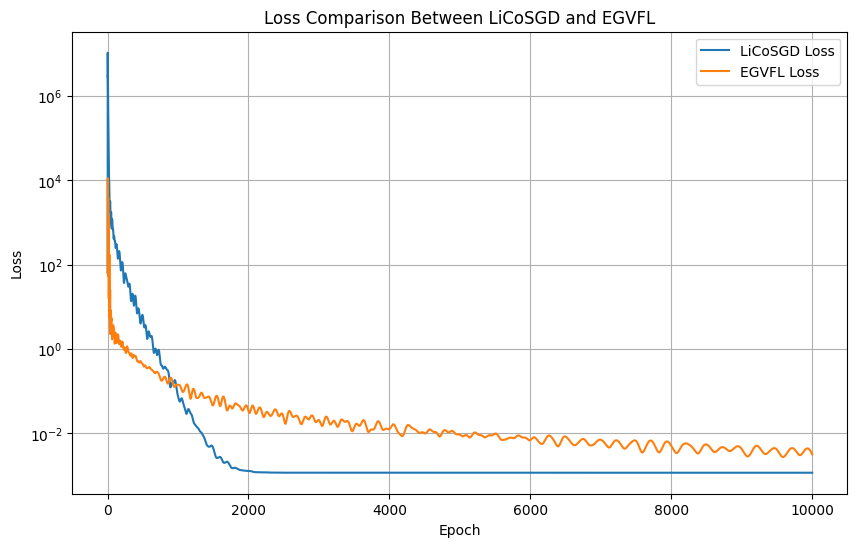

In [12]:
skipped = 0

plt.figure(figsize=(10, 6))
plt.yscale("log")
plt.plot(range((skipped + 1) * batch_size, (epoches + 1 + 1) * batch_size, batch_size), losses_lico[skipped:], label="LiCoSGD Loss")
plt.plot(range((skipped + 1) * batch_size, (epoches + 1 + 1) * batch_size, batch_size), losses_egvfl[skipped:], label="EGVFL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss Comparison Between LiCoSGD and EGVFL")
plt.legend()
plt.grid()
plt.show()